In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd

In [4]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [33]:
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


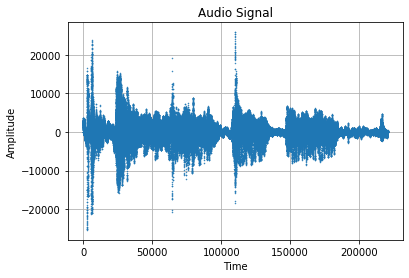

In [34]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Time", "Amplitude", "Audio Signal")

In [35]:
x.shape

(220500, 1)

In [36]:
L = np.convolve(x[:, 0], [1, 1]).astype(np.int32)

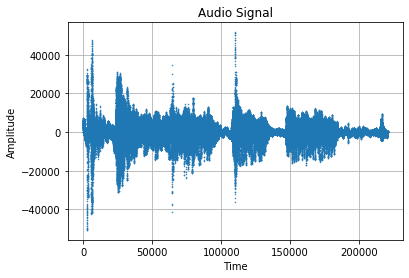

In [37]:
sd.play((L//2).astype(np.int16))
plot(np.linspace(0, len(L)-1, len(L)), L, "Time", "Amplitude", "Audio Signal")

In [38]:
H = np.convolve(x[:, 0], [1, -1]).astype(np.int32)

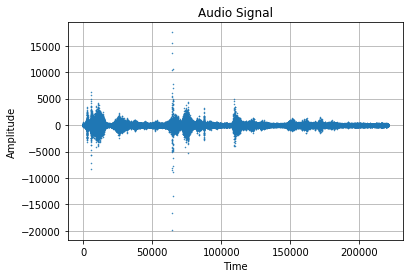

In [39]:
sd.play((H//2).astype(np.int16))
plot(np.linspace(0, len(H)-1, len(H)), H, "Time", "Amplitude", "Audio Signal")

In [40]:
L[::2] = 0
H[::2] = 0

In [41]:
L = np.convolve(L, [1, 1]).astype(np.int32)

In [42]:
H = np.convolve(H, [1, -1]).astype(np.int32)

In [43]:
_x = L+H

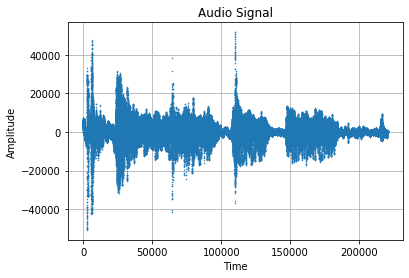

In [45]:
sd.play((_x//2).astype(np.int16))
plot(np.linspace(0, len(_x)-1, len(_x)), _x, "Time", "Amplitude", "Audio Signal")

In [46]:
x.all() == _x.all()

True